# Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [ ]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [ ]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [ ]:
# Building our data frame 
df = pd.DataFrame()

for i in range(0, 36):
  temp_df = pd.DataFrame(X_train[:, i, :])
  temp_df["user_id"] = i
  temp_df["label"] = y_train
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"ch_0", 1:"ch_1", 2:"ch_2", 3:"ch_3", 4:"ch_4", 5:"ch_5", })
print(df.shape)
df.head()

(87444, 8)


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id,label
0,17.5970,8.17130,-1.7842,-19.7060,-9.7135,-61.887,0,0
1,2.4209,-0.56039,23.6540,-3.8171,1.3721,8.251,0,0
2,39.6880,701.29000,3003.8000,34.8060,65.0360,77.808,0,0
3,1.6554,-1.94840,14.9890,-4.5047,-1.9535,16.397,0,0
4,-15.1390,5.36330,9.6577,-4.3281,-5.4659,22.605,0,0


In [ ]:
# Split over users
df_train = df[df['user_id'] <= 31]
df_test = df[df['user_id'] > 31]
df_train.shape, df_test.shape

((77728, 8), (9716, 8))

In [ ]:
# Apply MinMaxScaler to the useful features
scale_columns = ['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']
scaler = StandardScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

In [ ]:
window = 36
stride = 9

In [ ]:
def build_sequences(df, window=36, stride=6):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for l in df['label'].unique():
        # Take only meaningful features
        temp = df[df['label'] == l][['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']].values
        # Save the label
        label = df[df['label'] == l]['label'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(df_train, window, stride)
X_test, y_test = build_sequences(df_test, window, stride)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8636, 36, 8), (8636, 0, 6), (1076, 36, 8), (1076, 0, 6))

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

ValueError: ignored

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    # Left part
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    attention1 = SeqSelfAttention(attention_activation='sigmoid')(lstm)

    # Right part
    cnn_a = tfkl.Conv1D(128,7,padding='same',activation='relu')(input_layer)
    cnn_a = tfkl.Dropout(0.3)(cnn_a)
    attention2 = SeqSelfAttention(attention_activation='sigmoid')(cnn_a)

    cnn_b = tfkl.Conv1D(128,5,padding='same',activation='relu')(input_layer)
    cnn_b = tfkl.Dropout(0.3)(cnn_b)
    attention3 = SeqSelfAttention(attention_activation='sigmoid')(cnn_b)

    merged = tfkl.concatenate([attention1, attention2, attention3], axis=2)
    merged = tfkl.GlobalAveragePooling1D()(merged)

    dropout = tfkl.Dropout(.4, seed=seed)(merged)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 36, 128)      5504        ['Input[0][0]']                  
                                                                                                  
 conv1d_7 (Conv1D)              (None, 36, 128)      3968        ['Input[0][0]']                  
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 36, 256)     138240      ['Input[0][0]']                  
 )                                                                                            

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
61/61 [==============================] - 48s 683ms/step - loss: 1.7673 - accuracy: 0.4168 - val_loss: 12.9473 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 2/200
61/61 [==============================] - 24s 396ms/step - loss: 1.1564 - accuracy: 0.5932 - val_loss: 19.3948 - val_accuracy: 0.4155 - lr: 0.0010
Epoch 3/200
61/61 [==============================] - 24s 402ms/step - loss: 0.9793 - accuracy: 0.6429 - val_loss: 24.6486 - val_accuracy: 0.4421 - lr: 0.0010
Epoch 4/200
61/61 [==============================] - 24s 390ms/step - loss: 0.9004 - accuracy: 0.6744 - val_loss: 29.2612 - val_accuracy: 0.4306 - lr: 0.0010
Epoch 5/200
61/61 [==============================] - 24s 397ms/step - loss: 0.8754 - accuracy: 0.6868 - val_loss: 31.4479 - val_accuracy: 0.4190 - lr: 0.0010
Epoch 6/200
61/61 [==============================] - 24s 389ms/step - loss: 0.8280 - accuracy: 0.7012 - val_loss: 34.7787 - val_accuracy: 0.4317 - lr: 0.0010
Epoch 7/200
61/61 [==============================] -

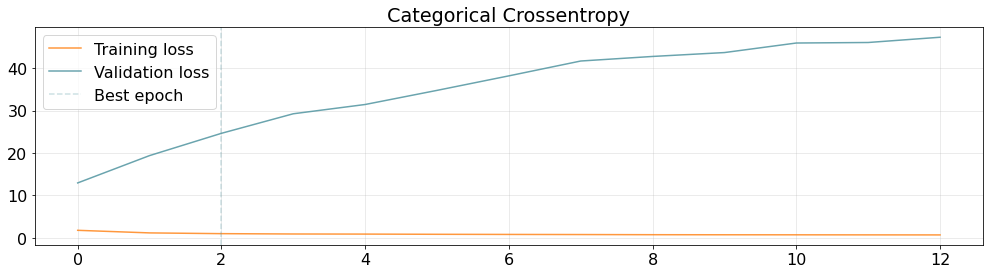

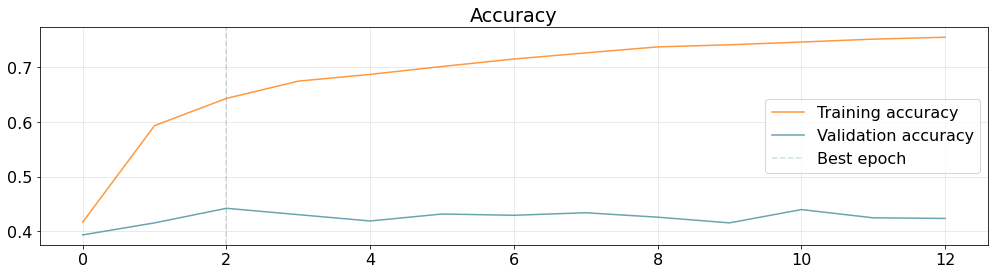

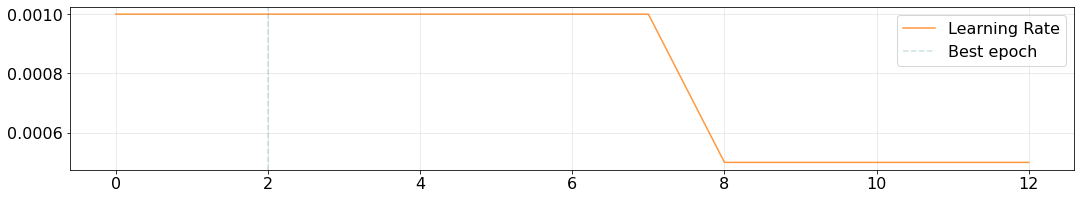

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('BiLSTM/attuation_parallel_norm')
# model = tfk.models.load_model('BiLSTM')

In [ ]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

34/34 [==============================] - 3s 46ms/step


(1068, 12)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6582
Precision: 0.4196
Recall: 0.4582
F1: 0.4235


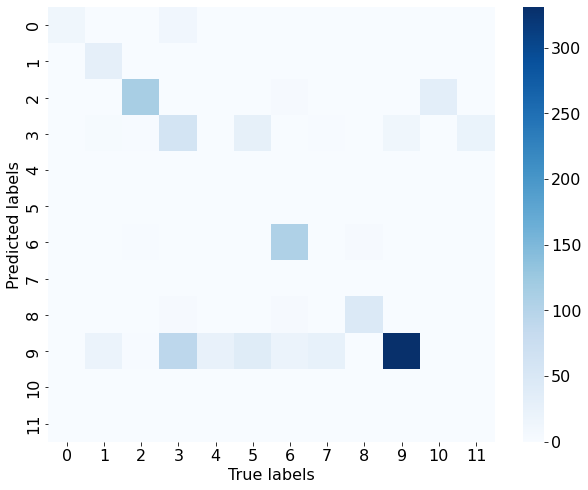

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()